# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Import the packages

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

### Read in the json files

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Explore the Data

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)

(10, 6)
(17000, 5)
(306534, 4)


The transcript data shows activity by customers - what type of events and how many?

In [7]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

Transaction is purchases, the rest relate to the offers that the customers received and how they reacted.

In [8]:
transcript.groupby('event').count()

,person,time,value
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


### Analysis Ideas
- Make some funnels for offers - to see if viewing the offer leads to increased likelihood of completing it
- Do the funnels vary by offer - if so, what drives it?
- Would a predictive model help us target offers better?

In [9]:
portfolio['id'].nunique() # 10 offers

10

In [10]:
transcript['value'].head() # will need to tidy this up for joining, split on colon

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

### Data Engineering
Let's convert the value column from a dictionary into separate columns

In [11]:
# separate out, drop original column
df_transcript = pd.concat([transcript.drop(['value'], axis=1), transcript['value'].apply(pd.Series)], axis=1) 
# coalesce two differently spelled offer id columns
df_transcript['offerID'] = df_transcript['offer id'].combine_first(df_transcript['offer_id']) 
# drop extra columns
df_transcript = df_transcript.drop(['offer id','offer_id'],axis=1) 

In [12]:
df_transcript.groupby('person').offerID.nunique().mean() # on average, each person received 3.7 offers

3.7228235294117646

Let's visualise how many people received 1,2,3 etc. offers

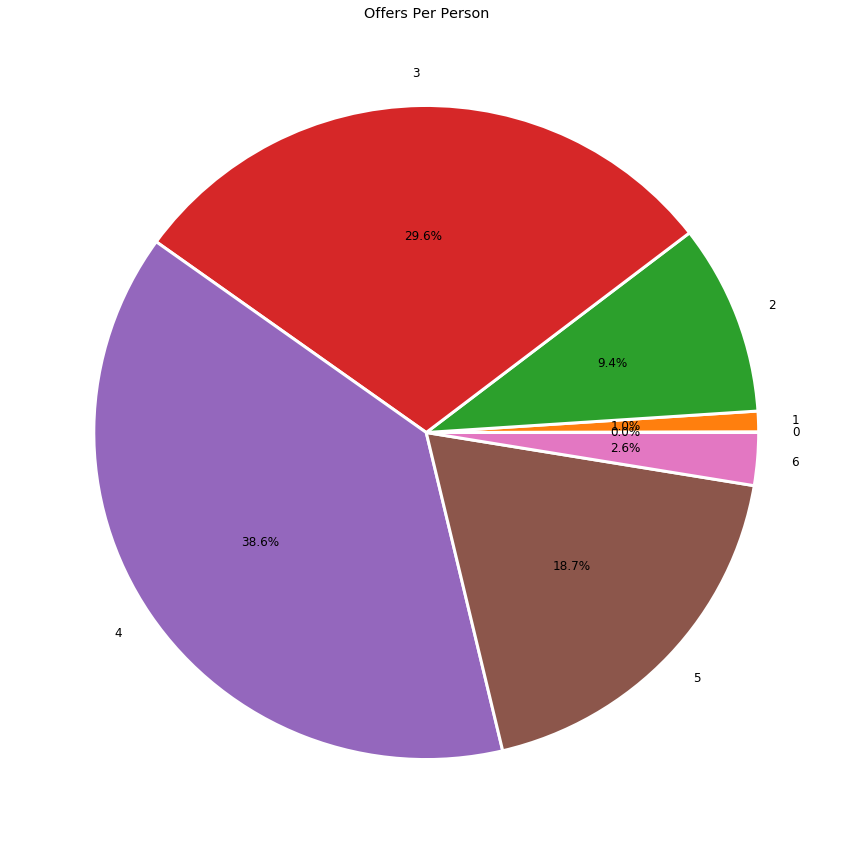

In [13]:
df_group = pd.DataFrame(df_transcript.groupby('person').offerID.nunique())
offersperperson = pd.DataFrame(df_group['offerID'].value_counts(sort=False))
offersperperson.reset_index(drop=False, inplace=True)

plt.rcParams['font.size'] = 12
x = offersperperson['offerID']
labels = offersperperson['index']
fig, ax = plt.subplots(figsize=(12, 12))
ax.pie(x, labels=labels, autopct='%.1f%%',wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},)
ax.set_title('Offers Per Person')
plt.tight_layout()

And see how many people participated in each offer:

In [14]:
df_transcript.groupby('offerID').person.nunique() 

offerID
0b1e1539f2cc45b7b9fa7c272da2e1d7    6374
2298d6c36e964ae4a3e7e9706d1fb8c2    6325
2906b810c7d4411798c6938adc9daaa5    6285
3f207df678b143eea3cee63160fa8bed    6331
4d5c57ea9a6940dd891ad53e9dbe8da0    6330
5a8bc65990b245e5a138643cd4eb9837    6320
9b98b8c7a33c4b65b9aebfe6a799e6d9    6355
ae264e3637204a6fb9bb56bc8210ddfd    6374
f19421c1d4aa40978ebb69ca19b0e20d    6262
fafdcd668e3743c1bb461111dcafc2a4    6332
Name: person, dtype: int64

Roughly similar volumes of customer have particpated in each offer

What are the potential journeys that each customer could have when they receive an offer?
- received, viewed, completed
- received, viewed, not completed
- received, not viewed, completed
- received, not viewed, not completed

Let's visualise how many people have completed each journey funnel:

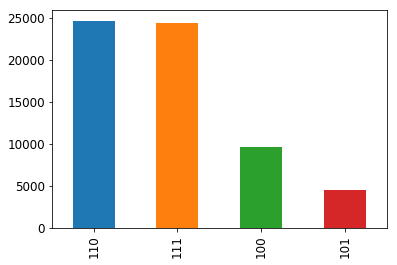

In [15]:
values = df_transcript['event'].unique()
for v in values:
    df_transcript[v]= [1 if x==v else 0 for x in df_transcript['event']]
df_journey = df_transcript.drop(['event','time','amount','reward','transaction'],axis=1)
df_journey = df_journey.groupby(['person','offerID']).max()
df_journey.reset_index(drop=False, inplace=True)
df_journey['journey']= df_journey['offer received'].map(str)+df_journey['offer viewed'].map(str)+df_journey['offer completed'].map(str)
df_journey = df_journey.drop(['offer received','offer viewed','offer completed'],axis=1)

df_journey['journey'].value_counts().plot(kind='bar')

### In-depth Analysis
The top level picture isn't very helpful, let's create a process which allows us to visualise the journey funnels grouped by offer and by each feature of the offers (e.g. channel, difficulty etc.). This should tell us more.

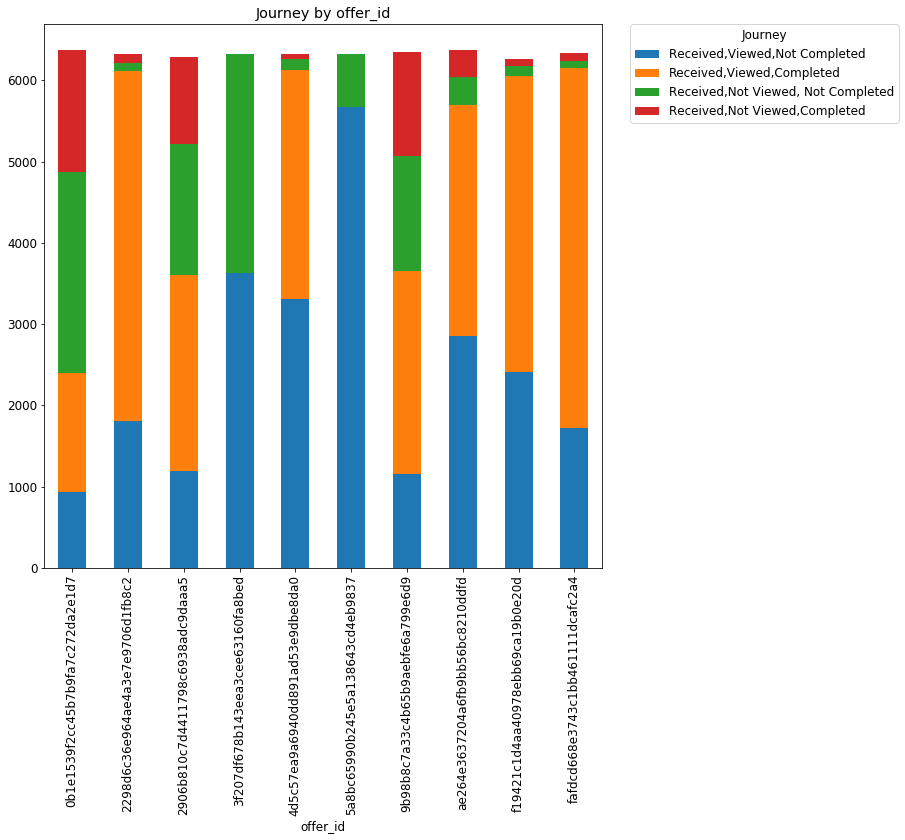

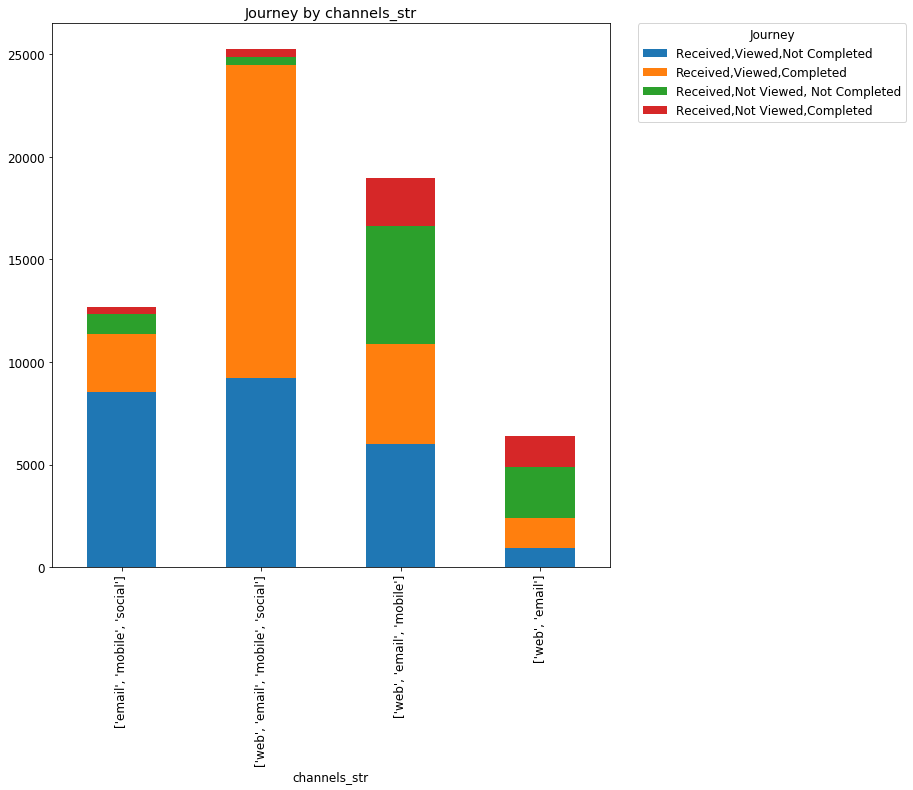

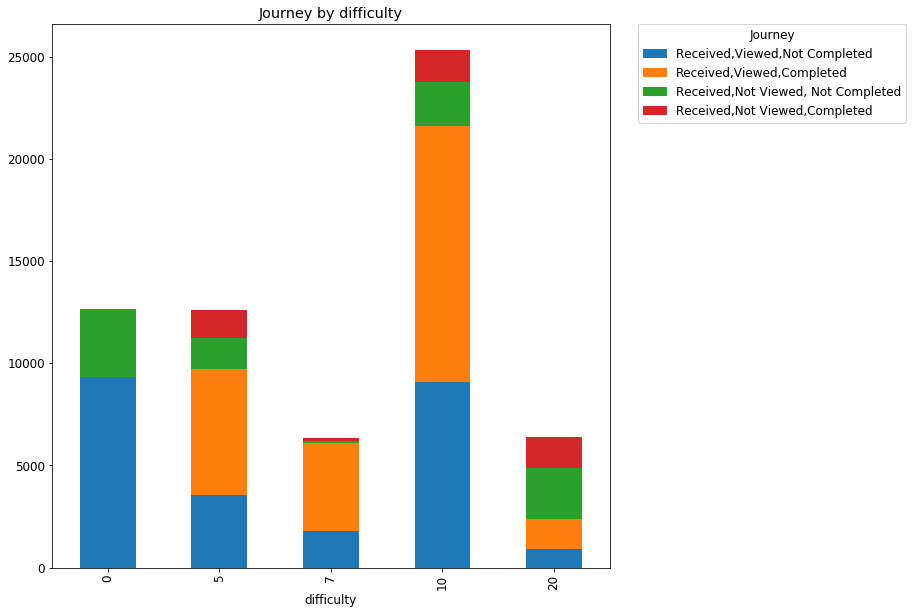

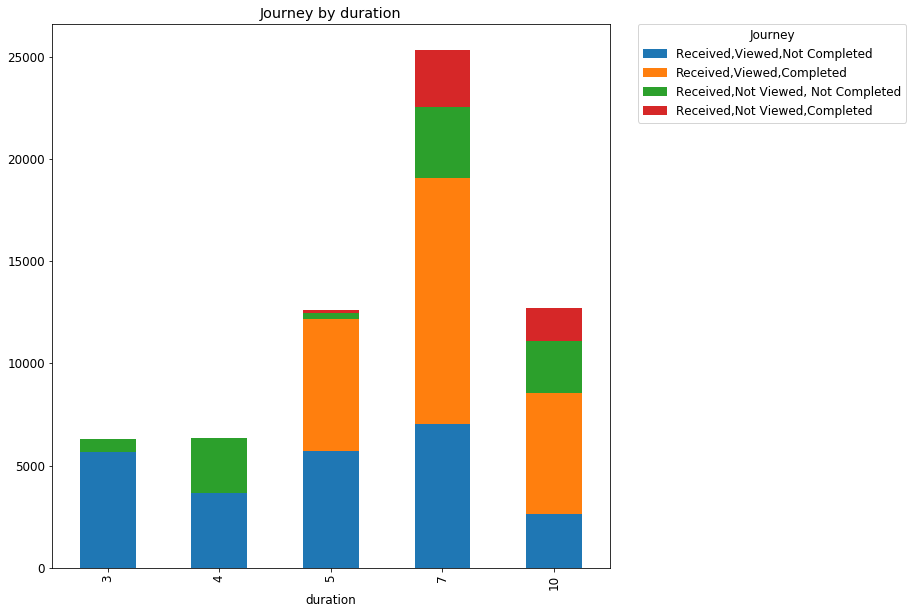

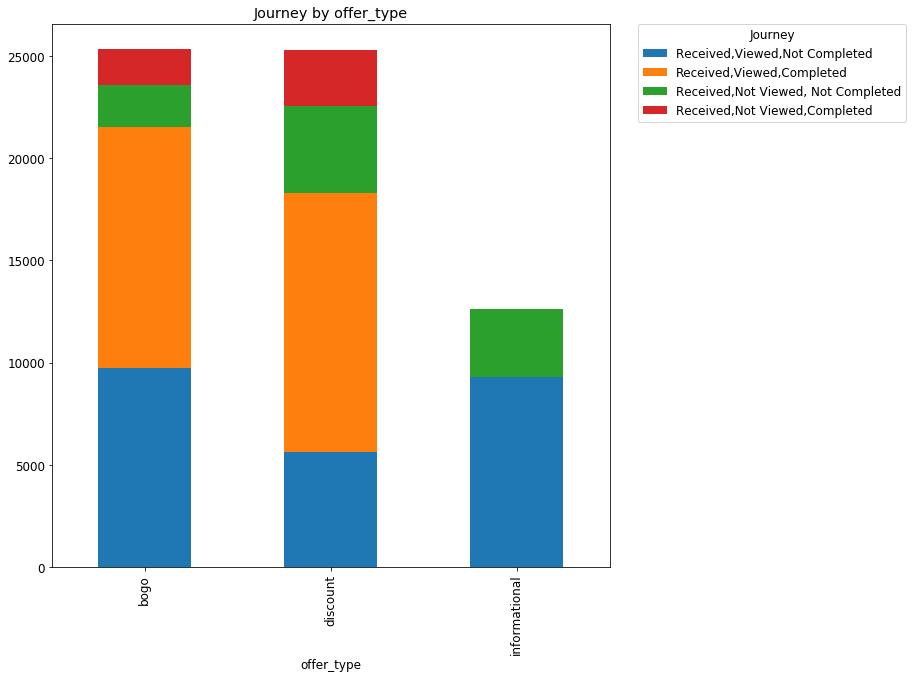

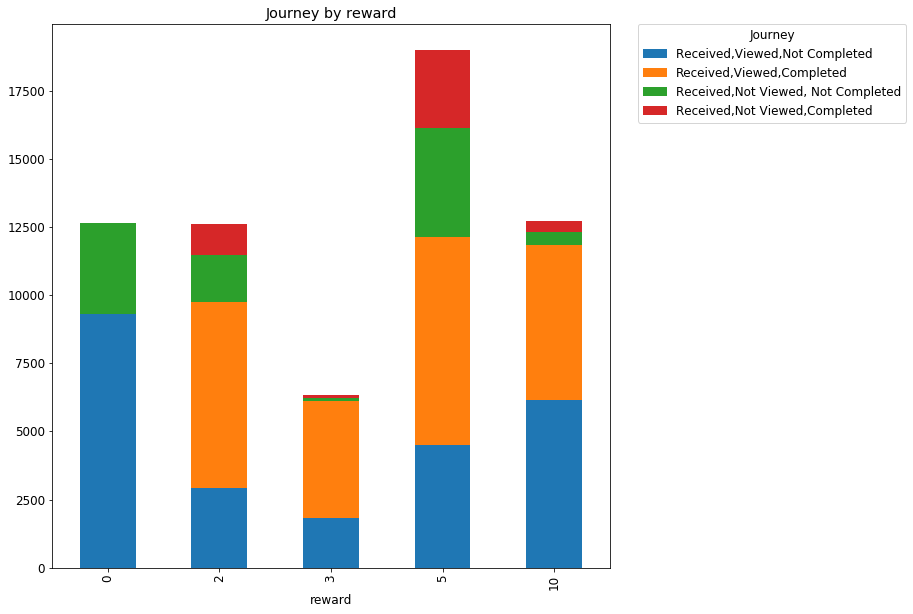

In [16]:
journeys = ['110','111','100','101']
journey_names = ['Received,Viewed,Not Completed','Received,Viewed,Completed','Received,Not Viewed, Not Completed','Received,Not Viewed,Completed']
offers = portfolio['id'].unique()

# collect the journey metrics for each offer
offer_journeys=[]
for o in offers:
    df_offer = df_journey[df_journey['offerID']==o]
    journey_count=[]
    for j in journeys:
        count = 0
        for x in df_offer['journey']:
            if x ==j:
                count+=1
        journey_count.append(count)
    offer_journeys.append(journey_count)
    
# combined offer journeys with offer info in one data frame
journey_df=pd.DataFrame(offer_journeys, columns=journey_names)#convert list of lists to df
journey_df['offer_id']=offers #add offer id column
cols = journey_df.columns.tolist() 
cols = cols[-1:] + cols[:-1]
journey_df = journey_df[cols] # re-order columns so ID is first
merged_df=journey_df.merge(portfolio, left_on='offer_id',right_on='id',how='inner')
merged_df=merged_df.drop('id',axis=1)
merged_df['channels_str'] = list(map(str, merged_df['channels']))

# 1 stacked bar overall by offer
# 1 by channels, 1 by difficulty, 1 by duration, 1 by offer type, 1 by reward
# iterate through to create multiple stacked bars
metric_cols = ['offer_id','channels_str','difficulty','duration','offer_type','reward']
for m in metric_cols:
    select_cols = []
    select_cols = journey_names[:]
    select_cols.append(m)
    select_cols = select_cols[-1:] + select_cols[:-1]
    merged_df[select_cols].groupby(m).sum().plot(kind='bar', stacked=True, figsize=(10,10))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Journey')
    plt.title('Journey by '+m, loc='center')

From this we can see the following:
- Each offer has a different journey profile - for example the fourth and sixth offers have not been completed at all
- If you look at "offer type", this explains it - they are "informational" so there is no expected action to complete
- Looking at channel suggests that using social media seems to increase the likelihood of people viewing offers

Looking at each factor in isolation is interesting but won't be the full picture - an offer's attractiveness will be a combination of its visibility, reward value, ease of completion and time available to complete.

And individual customers will be more or less likely to complete based on their own circumstances too.

### Predictive Modelling

A model can take into consideration all the factors when trying to predict whether a customer will respond to a particular campaign.

### More Data Engineering

Let's merge the transcript data with the customer profile data to create a dataset with one row per offer per person. We can get rid of columns we don't need and only keep the rows relating to offers, not transactions.

In [17]:
transcript_profile_df = df_transcript.merge(profile, left_on='person', right_on='id', how = 'inner')# merge transactions with customer profile
transcript_profile_df = transcript_profile_df.drop(['event','amount','transaction','id','time','reward'],axis=1)# drop unnecessary columns
transcript_profile_df = transcript_profile_df[transcript_profile_df['offerID'].notnull()]# only keep rows relating to offers
transcript_profile_grp = transcript_profile_df.groupby(['person','offerID','age','became_member_on','gender','income'])['offer received','offer viewed','offer completed'].max().reset_index()

I also want to quickly check if each offer was received by similar groups of customers, to check there are no biases which might impact the model.

In [19]:
transcript_profile_grp.groupby('offerID').agg({'age': ['min','max','mean', 'median']})

age                       
                                 min  max       mean median
offerID                                                    
0b1e1539f2cc45b7b9fa7c272da2e1d7  18  101  54.413744     55
2298d6c36e964ae4a3e7e9706d1fb8c2  18  101  54.264936     55
2906b810c7d4411798c6938adc9daaa5  18  101  54.122810     55
3f207df678b143eea3cee63160fa8bed  18  101  54.556481     55
4d5c57ea9a6940dd891ad53e9dbe8da0  18  100  54.198512     55
5a8bc65990b245e5a138643cd4eb9837  18  101  54.533805     55
9b98b8c7a33c4b65b9aebfe6a799e6d9  18  101  54.334536     55
ae264e3637204a6fb9bb56bc8210ddfd  18  100  54.239037     55
f19421c1d4aa40978ebb69ca19b0e20d  18  101  54.400367     55
fafdcd668e3743c1bb461111dcafc2a4  18  101  54.433802     56

In [34]:
transcript_profile_grp.groupby('offerID').agg({'became_member_on': ['min','max','mean', 'median']})

became_member_on                          \
                                              min       max          mean   
offerID                                                                     
0b1e1539f2cc45b7b9fa7c272da2e1d7         20130729  20180726  2.016684e+07   
2298d6c36e964ae4a3e7e9706d1fb8c2         20130729  20180726  2.016716e+07   
2906b810c7d4411798c6938adc9daaa5         20130730  20180726  2.016690e+07   
3f207df678b143eea3cee63160fa8bed         20130730  20180726  2.016699e+07   
4d5c57ea9a6940dd891ad53e9dbe8da0         20130731  20180726  2.016689e+07   
5a8bc65990b245e5a138643cd4eb9837         20130730  20180726  2.016685e+07   
9b98b8c7a33c4b65b9aebfe6a799e6d9         20130730  20180726  2.016684e+07   
ae264e3637204a6fb9bb56bc8210ddfd         20130729  20180726  2.016683e+07   
f19421c1d4aa40978ebb69ca19b0e20d         20130729  20180726  2.016704e+07   
fafdcd668e3743c1bb461111dcafc2a4         20130729  20180726  2.016693e+07   

                                            
                                    median  
offerID                                     
0b1e1539f2cc45b7b9fa7c272da2e1d7  20170728  
2298d6c36e964ae4a3e7e9706d1fb8c2  20170809  
2906b810c7d4411798c6938adc9daaa5  20170804  
3f207df678b143eea3cee63160fa8bed  20170806  
4d5c57ea9a6940dd891ad53e9dbe8da0  20170801  
5a8bc65990b245e5a138643cd4eb9837  20170730  
9b98b8c7a33c4b65b9aebfe6a799e6d9  20170803  
ae264e3637204a6fb9bb56bc8210ddfd  20170731  
f19421c1d4aa40978ebb69ca19b0e20d  20170804  
fafdcd668e3743c1bb461111dcafc2a4  20170807

In [35]:
transcript_profile_grp.groupby('offerID').agg({'income': ['min','max','mean', 'median']})

income                                 
                                      min       max          mean   median
offerID                                                                   
0b1e1539f2cc45b7b9fa7c272da2e1d7  30000.0  120000.0  65277.738010  64000.0
2298d6c36e964ae4a3e7e9706d1fb8c2  30000.0  120000.0  65447.975304  64000.0
2906b810c7d4411798c6938adc9daaa5  30000.0  120000.0  65476.459854  63000.0
3f207df678b143eea3cee63160fa8bed  30000.0  120000.0  65307.023896  64000.0
4d5c57ea9a6940dd891ad53e9dbe8da0  30000.0  120000.0  65270.731265  63000.0
5a8bc65990b245e5a138643cd4eb9837  30000.0  120000.0  65538.336052  63000.0
9b98b8c7a33c4b65b9aebfe6a799e6d9  30000.0  120000.0  65114.038253  63000.0
ae264e3637204a6fb9bb56bc8210ddfd  30000.0  120000.0  65587.347232  64000.0
f19421c1d4aa40978ebb69ca19b0e20d  30000.0  120000.0  65463.728191  63000.0
fafdcd668e3743c1bb461111dcafc2a4  30000.0  120000.0  65405.122655  64000.0

In [36]:
transcript_profile_grp.groupby(['offerID','gender']).agg({'offer received': ['sum']})

offer received
                                                   sum
offerID                          gender               
0b1e1539f2cc45b7b9fa7c272da2e1d7 F                2331
                                 M                3180
                                 O                  77
2298d6c36e964ae4a3e7e9706d1fb8c2 F                2256
                                 M                3170
                                 O                  81
2906b810c7d4411798c6938adc9daaa5 F                2265
                                 M                3142
                                 O                  73
3f207df678b143eea3cee63160fa8bed F                2288
                                 M                3155
                                 O                  81
4d5c57ea9a6940dd891ad53e9dbe8da0 F                2267
                                 M                3182
                                 O                  62
5a8bc65990b245e5a138643cd4eb9837 F                2313
                                 M                3122
                                 O                  82
9b98b8c7a33c4b65b9aebfe6a799e6d9 F                2295
                                 M                3161
                                 O                  86
ae264e3637204a6fb9bb56bc8210ddfd F                2288
                                 M                3198
                                 O                  78
f19421c1d4aa40978ebb69ca19b0e20d F                2247
                                 M                3121
                                 O                  77
fafdcd668e3743c1bb461111dcafc2a4 F                2258
                                 M                3214
                                 O                  72

They are pretty similar, which I guess you'd expect if their testing approach is set up correctly :-)

Grouping the data has got rid of the NaN records.

In [37]:
transcript_profile_grp.isna().sum()

person              0
offerID             0
age                 0
became_member_on    0
gender              0
income              0
offer received      0
offer viewed        0
offer completed     0
dtype: int64

There were originally c.2k where gender and income weren't populated:

In [38]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Let's look at the volume by offer to make sure none are disproportionately impacted:

In [39]:
transcript_profile_grp.groupby('offerID')['offer received','offer completed'].sum()

,offer received,offer completed
offerID,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,5588,2944
2298d6c36e964ae4a3e7e9706d1fb8c2,5507,4167
2906b810c7d4411798c6938adc9daaa5,5480,3383
3f207df678b143eea3cee63160fa8bed,5524,0
4d5c57ea9a6940dd891ad53e9dbe8da0,5511,2865
5a8bc65990b245e5a138643cd4eb9837,5517,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5542,3627
ae264e3637204a6fb9bb56bc8210ddfd,5564,3146
f19421c1d4aa40978ebb69ca19b0e20d,5445,3562


We have lost less than 15% of rows and pretty evenly shared across the offers.

### Even more Data Engineering

Now I am preparing my data for the model build:
- merging on campaign information
- dropping the rows which relate to informational offers as there's no completions for those
- separating out the channels
- using get dummies to convert text columns into binary flags
- renaming columns to make them nicer/easier to use

In [20]:
df_features = transcript_profile_grp.merge(portfolio, left_on='offerID', right_on='id',how='inner').drop('id',axis=1) # merge campaign features with customer profile and response metrics
df_features = df_features[df_features['offer_type']!='informational'].reset_index()# drop informational campaigns as they have no completions
df_features['channels_str'] = list(map(str, df_features['channels']))# turn channels into string and make flag for each
df_features['web'] = df_features.channels_str.str.contains('web')
df_features['email'] = df_features.channels_str.str.contains('email')
df_features['mobile'] = df_features.channels_str.str.contains('mobile')
df_features['social'] = df_features.channels_str.str.contains('social')
df_features = pd.get_dummies(df_features, columns=['gender','channels_str','offer_type']).drop(['index','channels'],axis=1)

# rename columns to make them nicer/easier to use
df_features.columns = ['person', 'offerID', 'age', 'became_member_on', 'income',
       'offer received', 'offer viewed', 'offer completed', 'difficulty',
       'duration', 'reward', 'web', 'email', 'mobile', 'social', 'gender_F',
       'gender_M', 'gender_O', 'channels_str_emailmobilesocial',
       'channels_str_webemailmobilesocial',
       'channels_str_webemailmobile',
       'channels_str_webemail', 'offer_type_bogo',
       'offer_type_discount']

In [21]:
df_features.shape

(44181, 24)

### Modelling

As the classes aren't too imbalanced, I will make a basic Logistic Regression model (default parameters) as the baseline. Then I'll try a basic Decision Tree (default parameters) to compare.

For the best performer out of these, I will build a pipeline and tune some parameters to see if I can improve performance.

Finally, I will do a business evaluation to translate model performance into real life considerations of whether to use it.

### Logistic Regression base line

In [55]:
X = df_features[['age','became_member_on', 'income', 'difficulty',
       'duration', 'reward', 'web', 'email', 'mobile', 'social', 'gender_F',
       'gender_M', 'gender_O', 'channels_str_emailmobilesocial',
       'channels_str_webemailmobilesocial',
       'channels_str_webemailmobile',
       'channels_str_webemail', 'offer_type_bogo',
       'offer_type_discount']] # these are the features

y = df_features['offer completed'] # this is the target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split train/test

print("Check train/test shapes: \n\r")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print()
# instantiate, fit and predict on train
model = LogisticRegression()
model.fit(X_train, y_train)
model.predict(X_train)
print("The training score is "+str(model.score(X_train, y_train)))
# predict on test
model.predict(X_test)
print("The test score is "+ str(model.score(X_test, y_test)))
print()
print("The training confusion matrix is: \n\r"+str(confusion_matrix(y_train, model.predict(X_train))))
print()
print("The test confusion matrix is: \n\r"+str(confusion_matrix(y_test, model.predict(X_test))))
print()

# get feature importances
coefs = np.array(model.coef_.reshape(-1))
feat_names=np.array(X_train.columns)
zipped = list(zip(feat_names,coefs))
feat_imp = pd.DataFrame(zipped, columns=['feature','coef'])
feat_imp['abs_coef']=np.abs(feat_imp['coef'])
print("Feature importance ranking: \n\r"+str(feat_imp.sort_values(by='abs_coef',ascending=False)))

Check train/test shapes: 

(29601, 19)
(29601,)
(14580, 19)
(14580,)

The training score is 0.65021451978
The test score is 0.645884773663

The training confusion matrix is: 
[[ 2790  8101]
 [ 2253 16457]]

The test confusion matrix is: 
[[1350 3998]
 [1165 8067]]

Feature importance ranking: 
                              feature          coef      abs_coef
2                              income  2.544764e-05  2.544764e-05
1                    became_member_on -5.352506e-08  5.352506e-08
0                                 age  1.509784e-08  1.509784e-08
3                          difficulty -4.711694e-09  4.711694e-09
5                              reward -4.541810e-09  4.541810e-09
4                            duration  9.005749e-10  9.005749e-10
11                           gender_M -8.090032e-10  8.090032e-10
10                           gender_F  7.826577e-10  7.826577e-10
14  channels_str_webemailmobilesocial  5.141056e-10  5.141056e-10
18                offer_type_discount  4.1850

The features at the top of the ranking are a mixture of customer profile and offer features, backing up my theory that the interplay between these is important when predicting completion.

### Decision Tree for comparison

In [56]:
# same train and test data as above

#instantiate model
tree = DecisionTreeClassifier()

# fit, predict and score on train
tree.fit(X_train,y_train)
tree.predict(X_train)
print("The training score is "+str(tree.score(X_train,y_train)))
# predict and score on test
tree.predict(X_test)
print("The test score is "+str(tree.score(X_test,y_test)))
print()
print("The training confusion matrix is: \n\r"+str(confusion_matrix(y_train, tree.predict(X_train))))
print()
print("The test confusion matrix is: \n\r"+str(confusion_matrix(y_test, tree.predict(X_test))))
print()
# get feature importances
coefs = tree.feature_importances_
feat_names = np.array(X_train.columns)
zipped = list(zip(feat_names,coefs))
feat_imp = pd.DataFrame(zipped, columns=['feature','importance'])
print("Feature importance ranking :\n\r"+str(feat_imp.sort_values(by='importance',ascending=False)))

The training score is 0.999898652073
The test score is 0.661865569273

The training confusion matrix is: 
[[10891     0]
 [    3 18707]]

The test confusion matrix is: 
[[2926 2422]
 [2508 6724]]

Feature importance ranking :
                              feature  importance
1                    became_member_on    0.391009
2                              income    0.223866
0                                 age    0.222124
5                              reward    0.034657
3                          difficulty    0.023114
11                           gender_M    0.023088
14  channels_str_webemailmobilesocial    0.015956
4                            duration    0.015376
9                              social    0.009031
10                           gender_F    0.008240
15        channels_str_webemailmobile    0.007883
13     channels_str_emailmobilesocial    0.005412
17                    offer_type_bogo    0.004988
6                                 web    0.004803
18                offer_

The Decision Tree is really over-fitted to the training data. On the test it performs similarly to the Logistic Regression. I will proceed with the Logistic Regression and use a pipeline and parameter tuning to try and improve it.

### Pipeline and GridSearch parameter tuning

In [57]:
# instantiate pipeline and grid search
pipeline = Pipeline([('scaler',StandardScaler()),('clf',LogisticRegression())])
params = {'clf__C': [0.001,0.01,0.1,1,10,100],
                'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
cv = GridSearchCV(pipeline, param_grid = params)

# fit, predict and score on training
cv.fit(X_train,y_train)
print("The training score of the best model is "+str(cv.score(X_train,y_train)))

# predict and score on test
print("The test score of the best model is "+str(cv.score(X_test,y_test)))
print()
print("The confusion matrix for the training is: \n\r"+str(confusion_matrix(y_train, cv.predict(X_train))))
print()
print("The confusion matrix for the test is: \n\r"+str(confusion_matrix(y_test, cv.predict(X_test))))

The training score of the best model is 0.705786966657
The test score of the best model is 0.703086419753

The confusion matrix for the training is: 
[[ 5033  5858]
 [ 2851 15859]]

The confusion matrix for the test is: 
[[2369 2979]
 [1350 7882]]


The scores have improved and the train/test are still performing to a similar level.

As we have built a model for all offers at once, I think we should check that it performs to a similar level for all of them.

In [58]:
pd.options.mode.chained_assignment = None # running below gives a warning but I can turn it off as the code is doing what I want it to
# turn X_train, y_train, train preds and train probs into a dataframe
pred_train = cv.predict(X_train)
proba_train = cv.predict_proba(X_train)[:,1] # just take probability of 1, probability of 0 is 1-probability of 1
pred_test = cv.predict(X_test)
proba_test = cv.predict_proba(X_test)[:,1] # just take probability of 1, probability of 0 is 1-probability of 1

X_train['pred'] = pd.Series(pred_train, index=X_train.index)
X_train['proba'] = pd.Series(proba_train, index=X_train.index)
X_train['actual'] = pd.Series(y_train, index=X_train.index)

X_test['pred'] = pd.Series(pred_test, index=X_test.index)
X_test['proba'] = pd.Series(proba_test, index=X_test.index)
X_test['actual'] = pd.Series(y_test, index=X_test.index)

# merge into one results dataframe
df_results = X_train.append(X_test, ignore_index=False)
df_results = df_results.sort_index()
df_results['offerID'] = df_features['offerID']
df_results['accurate'] = df_results['pred']== df_results['actual']

# group by offer to get performance by offer
df_offer_results = df_results.groupby('offerID').agg({'accurate': ['count', 'sum']}).reset_index()
df_offer_results['%accuracy'] = (df_offer_results.iloc[:,2]/df_offer_results.iloc[:,1])*100

df_offer_results

offerID accurate          %accuracy
                                       count     sum           
0  0b1e1539f2cc45b7b9fa7c272da2e1d7     5588  3737.0  66.875447
1  2298d6c36e964ae4a3e7e9706d1fb8c2     5507  4202.0  76.302887
2  2906b810c7d4411798c6938adc9daaa5     5480  3809.0  69.507299
3  4d5c57ea9a6940dd891ad53e9dbe8da0     5511  3668.0  66.557794
4  9b98b8c7a33c4b65b9aebfe6a799e6d9     5542  3849.0  69.451462
5  ae264e3637204a6fb9bb56bc8210ddfd     5564  3798.0  68.260244
6  f19421c1d4aa40978ebb69ca19b0e20d     5445  3770.0  69.237833
7  fafdcd668e3743c1bb461111dcafc2a4     5544  4310.0  77.741703

Fairly similar - a future project could investigate building separate models per offer, if Starbucks stick to similar offer templates.

### Real Life Model Application

Ultimately an accuracy score doesn't necessarily mean that much to the people in the marketing department. To get their buy-in for a model, I would need to think about how the model would be used in real life and prove it drives a benefit versus not using it.

This is where thinking about the confusion matrix and how that translates to outcomes is useful.

- If we contact all the people the model predicts will respond:
    * True Positives are good because the offer increases their spend
    * but False Positives will cost us money to contact and not increase their spend, and they might even get annoyed about contact for irrelevant offers (so they might even decrease their spend or take it to a competitor)
    
    
- If we don't contact the people the model predicts won't respond:
    * True Negatives are good because we save money by not marketing to them when they won't uplift their spend
    * but False Negatives are a missed opportunity, we will miss out on their incremental spend because we didn't tell them about the offer
    
To build our business case for using the model, I need the cost to market to each person and the expected incremental spend.

For example, let's imagine it costs £3.50 per person for marketing and each offer is expected to increase customer spend by £7.50.

(This is simplistic for sake of example, as in reality the channel mix for each offer would affect the costs and the offer types would likely drive different amounts of incremental spend)

In [2]:
total_TP = 15859 + 7882
total_TN = 5033 + 2369
total_FP = 5858 + 2979
total_FN = 2851 + 1350

c = 3.5
s = 7.5

total_costs = (total_TP*c) + (total_FP*c)
total_income = total_TP*s
cost_savings = (total_TN*c) + (total_FN*c)
missed_income = total_FN*s

without_model = (total_income+missed_income)-(total_costs+cost_savings)
with_model = total_income - total_costs

print("Without the model our campaign would generate £"+str(without_model))
print("With the model our campaign would generate £"+str(with_model))
print("The benefit of using the model is £"+str(with_model-without_model))

Without the model our campaign would generate £54931.5
With the model our campaign would generate £64034.5
The benefit of using the model is £9103.0


So in this example it would make sense to try using the model.

### Taking it further

Another option would be to use the probabilities, in conjunction with campaign costs.

For example, for an expensive campaign you might only contact people with >0.7 probability of responding but for a cheap campaign, you could contact everyone with >0.3 probability of responding and just avoid those really unlikely to respond.
You could also build a model to predict the amount of incremental spend per individual and use that in conjunction with both marketing cost and likelihood to respond to decide whether to include them in each campaign.

### Final comments

Analysis and modelling are interesting on their own, but what would make this truly valuable would be a close working relationship with the marketing department to understand their goals and constraints and use Data Science to inform their strategy.